In [1]:
from SimPEG import *
from SimPEG import maps as Maps
from simpegEM1D import EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, set_mesh_1d, piecewise_pulse
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from simpegEM1D import skytem_HM_2015, skytem_LM_2015
wave_HM = skytem_HM_2015()
wave_LM = skytem_LM_2015()
time_HM = np.logspace(-5, -2, 31)
time_LM = np.logspace(-5, -2, 31)

hz = get_vertical_discretization_time(
    np.unique(np.r_[time_HM, time_LM]), facter_tmax=0.5, factor_tmin=10., n_layer=30
)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

time_input_currents_HM = wave_HM.current_times[-7:]
input_currents_HM = wave_HM.currents[-7:]
time_input_currents_LM = wave_LM.current_times[-13:]
input_currents_LM = wave_LM.currents[-13:]

TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    topo = np.r_[0., 0., 100.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'general',
    src_type = 'CircularLoop',
    a = 13.,
    I = 1.,
    time = time_HM,
    time_input_currents=time_input_currents_HM,
    input_currents=input_currents_HM,
    n_pulse = 2,
    base_frequency = 25.,
    use_lowpass_filter=True,
    high_cut_frequency=210*1e3,
    moment_type='dual',
    time_dual_moment = time_HM,    
    time_input_currents_dual_moment=time_input_currents_LM,
    input_currents_dual_moment=input_currents_LM,
    base_frequency_dual_moment=210,    
)
sig_half = 1./50.
chi_half = 0.
expmap = Maps.ExpMap(mesh1D)

In [3]:
sig  = np.ones(TDsurvey.n_layer)*sig_half
eta  = np.zeros(TDsurvey.n_layer)
tau  = np.ones(TDsurvey.n_layer) * 0.001
c  = np.ones(TDsurvey.n_layer) * 0.7
blk_ind = (-30>LocSigZ) & (-50<LocSigZ)
sig[blk_ind] = 1./10.
eta[blk_ind] = 0.5
blk_ind = (-50>LocSigZ) & (-300<LocSigZ)
sig[blk_ind] = 1./1000.
blk_ind = -300>LocSigZ
sig[blk_ind] = 1./1000
m_true = np.log(sig)

[  50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.
   10.   10.   10.   10.   10.   10. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.] [  -0.           -3.9894228    -3.9894228    -8.37908847   -8.37908847
  -13.20915178  -13.20915178  -18.52379606  -18.52379606  -24.3716374
  -24.3716374   -30.80616931  -30.80616931  -37.88625213  -37.88625213
  -45.67665141  -45.67665141  -54.24863035  -54.24863035  -63.68060172
  -63.68060172  -74.05884514  -74.05884514  -85.47829631  -85.47829631
  -98.04341543  -98.04341543 -111.86914281 -111.86914281 -127.08195023
 -127.08195023 -143.82099791 -143.82099791 -162.23940743 -162.23940743
 -182.50566248 -182.50566248 -204.80515001 -204.80515001 -229.34185612
 -229.34185612 -256.34023204 -256.34023204 -286.04724725 -286.04724

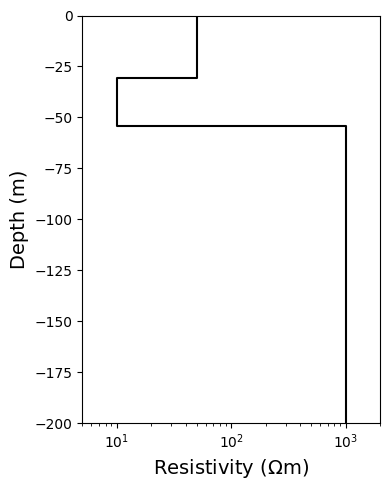

In [4]:
fig, ax = plt.subplots(1,1, figsize=(4, 5))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
ax.set_xlabel("Resistivity ($\Omega$m)")
ax.set_ylim(-200, 0.)
plt.tight_layout()
fig.savefig('resistivity', dpi=200)


In [6]:
%%time
prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False, eta=eta, tau=tau, c=c)
#if prob.ispaired:
#    prob.unpair()
#if TDsurvey.ispaired:
#    TDsurvey.unpair()
prob.survey = TDsurvey
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
d_true = TDsurvey.dpred(m_true)
# J = prob.getJ_sigma(m_true)

{'sigmaMap': <SimPEG.maps.ExpMap object at 0x7f8e24701a00>, 'verbose': False, 'eta': array([0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0.5, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. ]), 'tau': array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001]), 'c': array([0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7])}


AttributeError: 'EM1D' object has no attribute 'pair'

In [8]:
prob.mapPair?

In [114]:
%%time
prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
d_true_em = TDsurvey.dpred(m_true)
# J = prob.getJ_sigma(m_true)

CPU times: user 141 ms, sys: 16.5 ms, total: 158 ms
Wall time: 107 ms


In [115]:
np.random.seed(1)
TDsurvey.dtrue = d_true
std = 0.05
noise = std*abs(TDsurvey.dtrue)*np.random.randn(*TDsurvey.dtrue.shape)
floor = 0.
std = 0.1
TDsurvey.dobs = TDsurvey.dtrue+noise
uncert = abs(TDsurvey.dobs)*std+floor

In [116]:
dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
uncert = (abs(TDsurvey.dobs)*std+floor)
dmisfit.W = 1./ uncert

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [117]:
d_true_ip = d_true - d_true_em

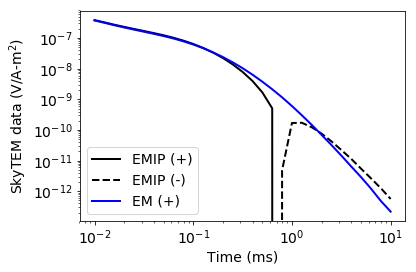

In [122]:
fig, axes = subplots(1,1, figsize = (6,4))
axes.plot(TDsurvey.time*1e3, -d_true[:TDsurvey.n_time], '-', lw=2, color='k')
axes.plot(TDsurvey.time*1e3, d_true[:TDsurvey.n_time], '--', lw=2, color='k')
axes.plot(TDsurvey.time*1e3, -d_true_em[:TDsurvey.n_time], '-', lw=2, color='b')
axes.set_xscale('log');
axes.set_yscale('log');
plt.legend(("EMIP (+)", "EMIP (-)", "EM (+)"), loc=3)
plt.xlabel("Time (ms)")
plt.ylabel("SkyTEM data (V/A-m$^2$)")
plt.tight_layout()
# fig.savefig('skytem_data', dpi=200)

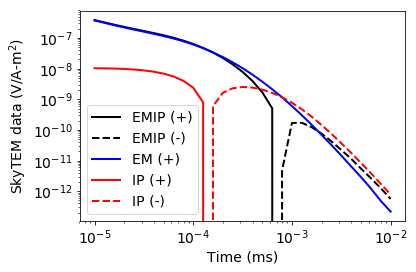

In [123]:
fig, axes = subplots(1,1, figsize = (6,4))
axes.plot(TDsurvey.time, -d_true[:TDsurvey.n_time], '-', lw=2, color='k')
axes.plot(TDsurvey.time, d_true[:TDsurvey.n_time], '--', lw=2, color='k')
axes.plot(TDsurvey.time, -d_true_em[:TDsurvey.n_time], '-', lw=2, color='b')
axes.plot(TDsurvey.time, -d_true_ip[:TDsurvey.n_time], '-', lw=2, color='r')
axes.plot(TDsurvey.time, d_true_ip[:TDsurvey.n_time], '--', lw=2, color='r')
axes.set_xscale('log');
axes.set_yscale('log');
plt.legend(("EMIP (+)", "EMIP (-)", "EM (+)","IP (+)", "IP (-)"), loc=3)
plt.xlabel("Time (ms)")
plt.ylabel("SkyTEM data (V/A-m$^2$)")
plt.tight_layout()
# fig.savefig('skytem_data', dpi=200)